In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ct_q76qj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ct_q76qj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader, random_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import clip

In [4]:
# Load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.6MiB/s]


In [5]:
# Load STL10 dataset and create train/test split
dataset = STL10(root="./", split='train', download=True, transform=clip_preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 2.64G/2.64G [00:42<00:00, 62.3MB/s]


In [8]:
# Dummy SimCLR & BYOL models (replace with trained models or load checkpoints)
class DummyEncoder(torch.nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3 * 224 * 224, 512),  # Adjusted input size for STL10
            torch.nn.ReLU(),
            torch.nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

simclr_model = DummyEncoder().to(device)
byol_model = DummyEncoder().to(device)
simclr_model.eval()
byol_model.eval()

DummyEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
)

In [9]:
# Extract embeddings for training data
train_features = []
train_labels = []
with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        clip_feats = clip_model.encode_image(images)
        simclr_feats = simclr_model(images)
        byol_feats = byol_model(images)

        fused_feats = torch.cat([clip_feats, simclr_feats, byol_feats], dim=1)
        train_features.append(fused_feats.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features).numpy()
train_labels = torch.cat(train_labels).numpy()
train_features = normalize(train_features)

In [18]:
# KMeans Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_features)
train_pred_labels = kmeans.labels_

In [11]:
# Extract embeddings for test data
test_features = []
test_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        clip_feats = clip_model.encode_image(images)
        simclr_feats = simclr_model(images)
        byol_feats = byol_model(images)

        fused_feats = torch.cat([clip_feats, simclr_feats, byol_feats], dim=1)
        test_features.append(fused_feats.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features).numpy()
test_labels = torch.cat(test_labels).numpy()
test_features = normalize(test_features)


In [12]:
# Predict on test data
test_pred_labels = kmeans.predict(test_features)

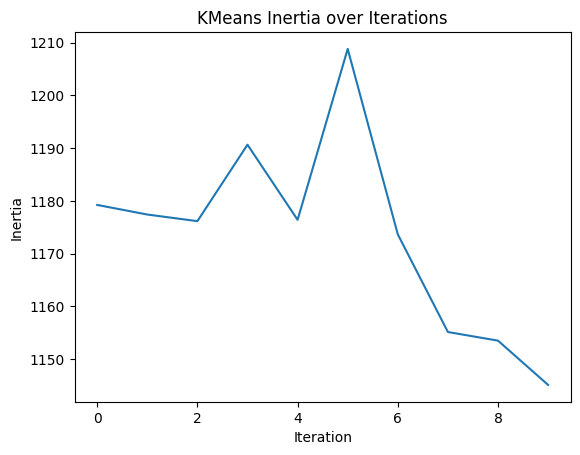

In [14]:
inertia_values = []
for i in range(10):
  kmeans = KMeans(n_clusters=10, random_state=i)
  kmeans.fit(train_features)
  inertia_values.append(kmeans.inertia_)

plt.plot(inertia_values)
plt.xlabel("Iteration")
plt.ylabel("Inertia")
plt.title("KMeans Inertia over Iterations")
plt.show()

Accuracy on Test Data: 0.974

Classification Report on Test Data:
               precision    recall  f1-score   support

           0     1.0000    0.9767    0.9882        86
           1     0.9909    0.9820    0.9864       111
           2     0.9677    0.9677    0.9677        93
           3     0.9900    0.9167    0.9519       108
           4     0.9380    0.9918    0.9641       122
           5     0.9694    1.0000    0.9845        95
           6     1.0000    0.9655    0.9825        87
           7     0.9541    0.9720    0.9630       107
           8     0.9773    0.9885    0.9829        87
           9     0.9714    0.9808    0.9761       104

    accuracy                         0.9740      1000
   macro avg     0.9759    0.9742    0.9747      1000
weighted avg     0.9746    0.9740    0.9740      1000



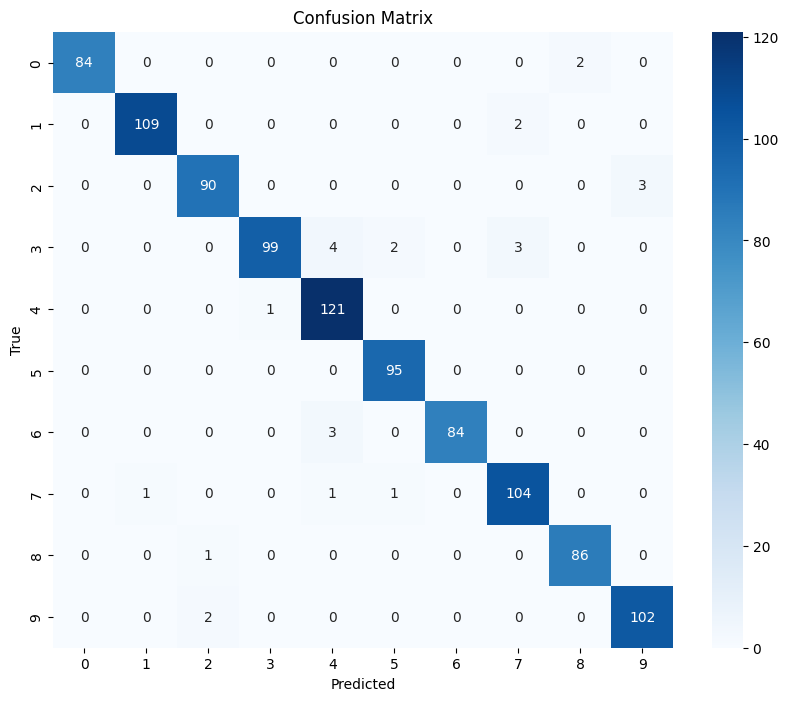

In [15]:
# Evaluation on test data
# Map predicted clusters to true labels using Hungarian algorithm
from scipy.optimize import linear_sum_assignment

conf_matrix = confusion_matrix(test_labels, test_pred_labels)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
mapping = dict(zip(col_ind, row_ind))
test_pred_mapped = np.vectorize(mapping.get)(test_pred_labels)

acc = accuracy_score(test_labels, test_pred_mapped)
report = classification_report(test_labels, test_pred_mapped, digits=4)
conf_matrix_mapped = confusion_matrix(test_labels, test_pred_mapped)

print("Accuracy on Test Data:", acc)
print("\nClassification Report on Test Data:\n", report)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mapped, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

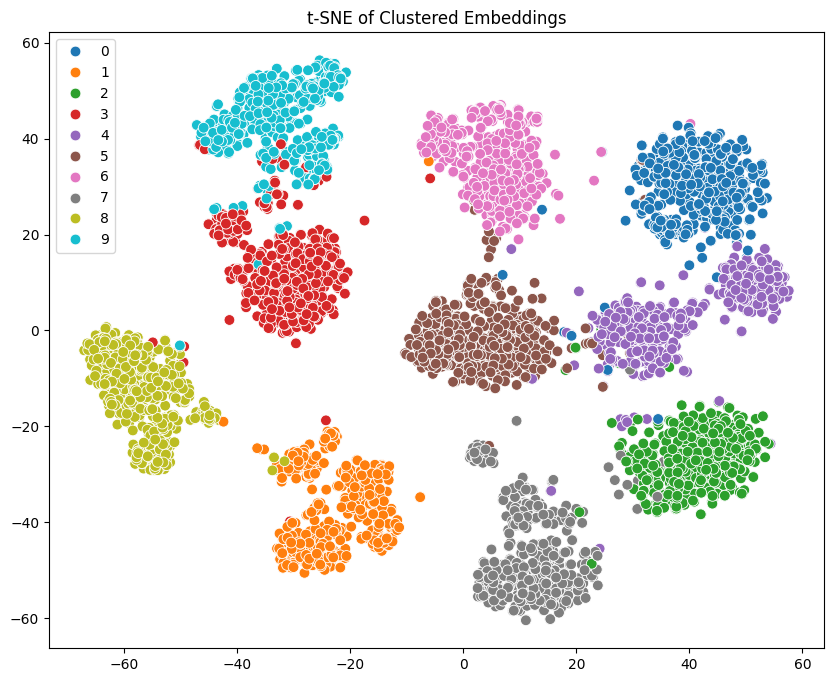

In [19]:
# t-SNE Visualization
# Combine train and test features for visualization
all_features = np.concatenate([train_features, test_features])
all_pred_labels = np.concatenate([train_pred_labels, test_pred_labels])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=all_pred_labels, palette='tab10', s=60, legend='full')
plt.title("t-SNE of Clustered Embeddings")
plt.show()